
<h2><strong>PYTHON_PRO'S

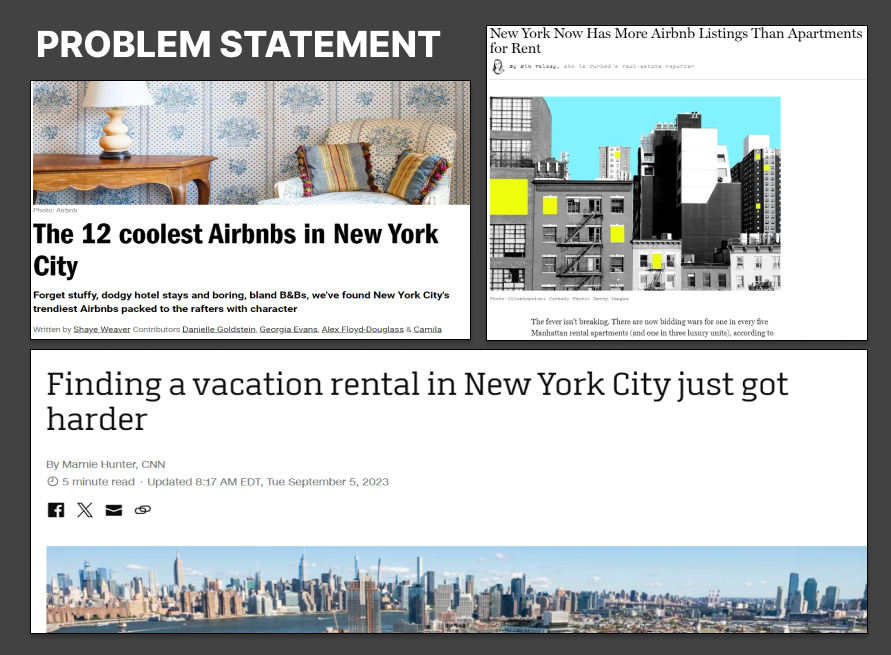

Investigation on high Airbnb listings in New York and exploring the factors contributing to the high prices in the Airbnb market.

## **PROJECT OVERVIEW**

# Objective:
Comprehensive analysis of the New York City Airbnb market to provide actionable insights for hosts and Customers.

# Key Focus Areas:
Explored geographical distribution, pricing dynamics, customer experiences, and availability patterns in the dataset.

# Data Utilization:
Leveraged latitude/longitude coordinates for geographical visualization and analyze crucial metrics like price, reviews, and availability.

<h2><em><strong>Importing all required packages and libraries

In [1]:

import sqlite3
import pandas as pd
import numpy as np

import sqlite3
from sqlite3 import Error
import os

from tabulate import tabulate

import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

<ipython-input-1-374b66008b35>:20: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-1-374b66008b35>:21: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<h2><em><strong>Function for Parsing the Tsv file for getting header and data

In [2]:

def read_file(file_name):
  with open(file_name, 'r', encoding='utf-8') as inp_file:
    header =[]
    listing_data=[]
    for line in inp_file:
      if line.strip():
        if not header:
          header = line.strip('\n').split('\t')
        else :
          line = line.strip('\n').split('\t')
          listing_data.append(line)
    #print(header)
  return header, listing_data

<h2><em><strong>Reading the file for collecting header and listing data

In [3]:
header, listing_data = read_file('airbnbRawDataV2.tsv')


<h2><em><strong>Data Cleaning


In [4]:


def clean_data(h, l_data):
  id_index = h.index('id')
  review_ind = h.index('last_review')
  name_index = h.index('name')

  ## changing few column names to be more readable
  h[id_index] = 'listing_id'
  h[name_index] = 'listing_name'
  ## deleting unwanted columns
  del h[review_ind]
  lst_cnt_ind = h.index('calculated_host_listings_count')
  del h[lst_cnt_ind]
  ## deleting unwanted colunns in listing data
  for line in l_data:
    del line[review_ind]
    del line[lst_cnt_ind]
  return h,l_data

<h2><em><strong>Data Collection Process

In [5]:

c_header, c_listing_data = clean_data(header, listing_data)
print(c_header)

['listing_id', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'listing_name']


<h2><em><strong>Database Setup and SQL Operations Functions

In [6]:
#Function for creating the connection of the database
#delete_db, if given true will delete the existinf db_file and create a new one


def create_connection(db_file, delete_db=False):
  if delete_db and os.path.exists(db_file):
    os.remove(db_file)
  conn = None
  try:
    conn = sqlite3.connect(db_file)
    conn.execute("PRAGMA foreign_keys = 1")
  except Error as e:
    print(e)

  return conn


#Function for creating tables in the database
#drop_table_name, if given table name will drop the table from the database


def create_table(conn, create_table_sql, drop_table_name=None):
  if drop_table_name:
    try:
      c = conn.cursor()
      c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
    except Error as e:
      print(e)

  try:
    c = conn.cursor()
    c.execute(create_table_sql)
  except Error as e:
    print(e)


#Function for executing given SQL statements and return rows


def execute_sql_statement(sql_statement, conn):

  cur = conn.cursor()
  cur.execute(sql_statement)
  rows = cur.fetchall()
  return rows


#Function for inserting data into the database


def insert_rows(sql_statement, values, conn):

  cur = conn.cursor()
  cur.executemany(sql_statement, values)
  return cur.lastrowid


In [7]:
#creating a database connection
norm_conn = create_connection('airbnb.db', True)

<h2><font color = maroon><strong> NORMALIZATION
<h2><em><strong>Creating Host, Neighborhood and Listings Table
<p>We've identified transitive dependencies in our original data, so we have created a normalized database comprising 3 tables: a Host Table (HostID primary key), a Neighborhood Table (NeighborhoodID primary key), and a Listing Table (ListingID primary key) that has both HostID and NeighborhoodID as Foreign keys.



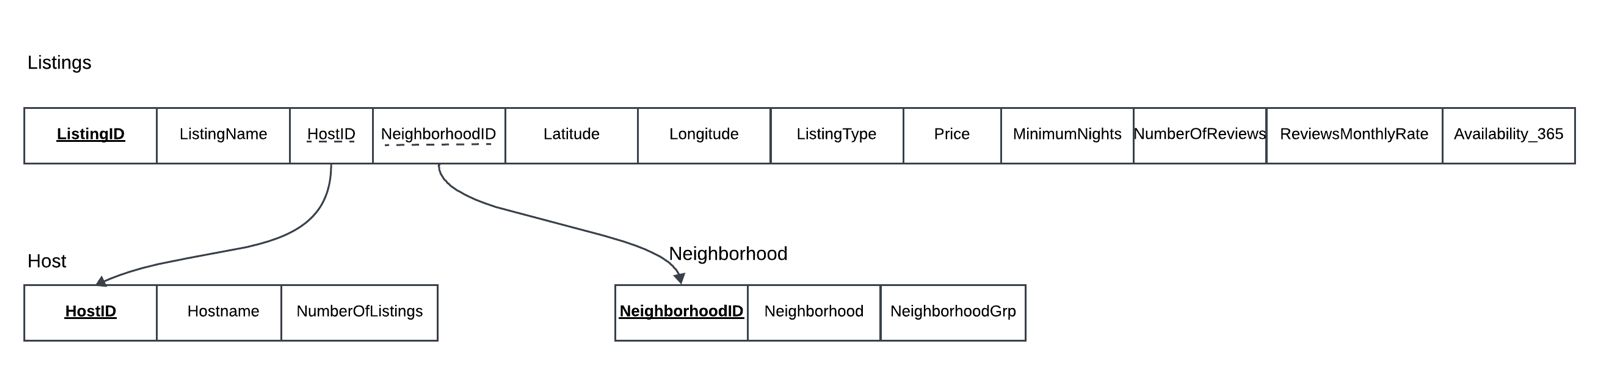

In [8]:


def create_host_table(header, l_data, norm_conn):
  create_host_sql = '''CREATE TABLE IF NOT EXISTS [Host] (
  [HostID] INTEGER NOT NULL PRIMARY KEY,
  [HostName] TEXT NOT NULL,
  [NumberOfListings] INTEGER NOT NULL);'''
  create_table(norm_conn, create_host_sql,'Host')
  hi = header.index('host_id')
  hni = header.index('host_name')
  hosts = []
  hostset = set()
  hostcount = {}
  for line in l_data:
    host_id = line[hi]
    host_name = line[hni]
    if host_id in hostcount.keys():
       hostcount[host_id] += 1
    if host_id not in hostset:
      hostcount[host_id] = 1
      hostset.add(host_id)
      hosts.append([host_id,host_name])
  for host in hosts:
    id = host[0]
    host.append(hostcount[id])
  hosts = [tuple(host) for host in hosts]
  with norm_conn:
    insert_host = '''INSERT INTO Host (HostID, HostName, NumberOfListings) VALUES (?,?, ?)'''
    insert_rows(insert_host, hosts, norm_conn)



## Creating Neighborhood table
def create_neighborhood_table(header,l_data, norm_conn):
  create_neighborhood_sql = '''CREATE TABLE IF NOT EXISTS [Neighborhood] (
   [NeighborhoodID] INTEGER NOT NULL PRIMARY KEY,
   [Neighborhood] TEXT NOT NULL,
   [NeighborhoodGroup] TEXT NOT NULL);'''
  insert_neighborhood_sql = "INSERT INTO Neighborhood(Neighborhood, NeighborhoodGroup) VALUES(?,?)"
  create_table(norm_conn,create_neighborhood_sql,'Neighborhood')
  ans_lst,nbh_lst=[],[]
  ngi = header.index('neighbourhood_group')
  ni = header.index('neighbourhood')
  with norm_conn:
     cnt_dict= {}
     neighh_set=set()
     for line in l_data:
       neighborhood_grp = line[ngi]
       neighborhood = line[ni]
       if neighborhood not in cnt_dict.keys():
         cnt_dict[neighborhood] = neighborhood_grp
         nbh_lst.append((neighborhood,neighborhood_grp))
     insert_neighborhood_sql = "INSERT INTO Neighborhood(Neighborhood, NeighborhoodGroup) VALUES(?,?)"
     insert_rows(insert_neighborhood_sql,nbh_lst,norm_conn)


def neighbourhood_dictionary(normalized_database_filename):

  with norm_conn:
    neighbourhood = {}
    sql_statement = 'SELECT [NeighborhoodID],[Neighborhood]  FROM [Neighborhood]'
    locations = execute_sql_statement(sql_statement, norm_conn)
    neigh_dict = {value[1]: value[0] for value in locations}
  return neigh_dict


## Creating Listings table
def create_listings_table(header, l_data, norm_conn):

  create_listings_sql = '''CREATE TABLE IF NOT EXISTS [Listing](
    [ListingID] INTEGER NOT NULL PRIMARY KEY,
    [ListingName] TEXT NOT NULL,
    [HostID] INTEGER NOT NULL,
    [NeighborhoodID] INTEGER NOT NULL,
    [Latitude] REAL NOT NULL,
    [Longitude] REAL NOT NULL,
    [ListingType] TEXT NOT NULL,
    [Price] INTEGER NOT NULL,
    [MinimumNights] INTEGER NOT NULL,
    [NumberOfReviews] INTEGER,
    [MonthlyReviewRate] INTEGER,
    [Availability_365] INTEGER NOT NULL,
    FOREIGN KEY(HostID) REFERENCES Host(HostID),
    FOREIGN KEY(NeighborhoodID) REFERENCES Neighborhood(NeighborhoodID)
    )'''
  create_table(norm_conn,create_listings_sql, 'Listing')
  ListingNames = []
  li = header.index("listing_id")
  lni = header.index("listing_name")
  hosti = header.index("host_id")
  nhi = header.index("neighbourhood")
  lati = header.index("latitude")
  longi = header.index("longitude")
  roomti = header.index("room_type")
  pricei = header.index("price")
  minni = header.index("minimum_nights")
  revi = header.index("number_of_reviews")
  rev_ratei = header.index("reviews_per_month")
  availi = header.index("availability_365")
  FKneigh = neighbourhood_dictionary('airbnb.db')
  with norm_conn:
    for line in l_data:
      listing_id = line[li]
      listing_name = line[lni]
      host_id = line[hosti]
      neighborhood = line[nhi]
      neigh_id = FKneigh[neighborhood]
      latitude = line[lati]
      longitude = line[longi]
      room_type = line[roomti]
      price = line[pricei]
      minimum_nights = line[minni]
      number_of_reviews = line[revi]
      MonthlyReviewRate = line[rev_ratei]
      Availability_365 = line[availi]
      ListingNames.append( (listing_name,host_id,neigh_id, latitude,longitude,room_type,price,minimum_nights, number_of_reviews,MonthlyReviewRate,Availability_365))

    insert_listings_sql = "INSERT INTO Listing(ListingName,HostID,NeighborhoodID,Latitude,Longitude,ListingType,Price,MinimumNights,NumberOfReviews,MonthlyReviewRate,Availability_365) VALUES(?,?,?,?,?,?,?,?,?,?,?)"
    insert_rows(insert_listings_sql,ListingNames,norm_conn)

In [9]:
##Creation of new tables and inserting data into the tables (HOST , LISTING, Neighborhood)
create_host_table(c_header, c_listing_data, norm_conn)
create_neighborhood_table(c_header,c_listing_data, norm_conn)
create_listings_table(c_header, c_listing_data, norm_conn)

<h1> Glance on the data after normalization </h1>

In [10]:
hostsql = "SELECT * FROM Host LIMIT 5"
neighborsql = "SELECT * FROM Neighborhood LIMIT 5"
listingsql = "SELECT * FROM Listing LIMIT 5"

dfh = pd.read_sql_query(hostsql, norm_conn)
dfn = pd.read_sql_query(neighborsql, norm_conn)
dfl = pd.read_sql_query(listingsql, norm_conn)

#Printing the tables

print("Host Table:")
print(tabulate(dfh, headers='keys', tablefmt='pretty'))

print("\nNeighborhood Table:")
print(tabulate(dfn, headers='keys', tablefmt='pretty'))

print("\nListing Table:")
print(tabulate(dfl, headers='keys', tablefmt='pretty'))

Host Table:
+---+--------+----------+------------------+
|   | HostID | HostName | NumberOfListings |
+---+--------+----------+------------------+
| 0 |  2438  |  Tasos   |        1         |
| 1 |  2571  |  Teedo   |        1         |
| 2 |  2787  |   John   |        6         |
| 3 |  2845  | Jennifer |        2         |
| 4 |  2868  | Letha M. |        1         |
+---+--------+----------+------------------+

Neighborhood Table:
+---+----------------+--------------+-------------------+
|   | NeighborhoodID | Neighborhood | NeighborhoodGroup |
+---+----------------+--------------+-------------------+
| 0 |       1        |  Kensington  |     Brooklyn      |
| 1 |       2        |   Midtown    |     Manhattan     |
| 2 |       3        |    Harlem    |     Manhattan     |
| 3 |       4        | Clinton Hill |     Brooklyn      |
| 4 |       5        | East Harlem  |     Manhattan     |
+---+----------------+--------------+-------------------+

Listing Table:
+---+-----------+-------

<h1><strong><em><font color=maroon>Performing Exploratory Data Analysis

<h2><strong><font color = green>Visualization1

<h3><em><strong>Distribution of AIRBNB Listings by Neighborhood Group IN NYC

In [11]:
sql1= "Select N.NeighborhoodGroup, count(L.ListingID) as Count_of_Listings, round((count(L.ListingID)*100.0/ (Select count(*) from Listing)),2) as perct_count From Listing as L JOIN Neighborhood as N ON N.NeighborhoodID = L.NeighborhoodID Group by N.NeighborhoodGroup"
df1 = pd.read_sql_query(sql1, norm_conn)
fig1 = px.pie(df1,
   names='NeighborhoodGroup',
   values='perct_count',
   hole=0.4,
   title='Listings by Neighborhood Group',
   labels={'perct_count': 'Percentage of Total Listings'},
   color='NeighborhoodGroup',
   template='plotly',  # You can choose a different template if needed
  )

fig1.update_layout(
    legend_title_text='Neighborhood Group',
    width=700  # Adjust the width as needed
)


fig1.show()

<h3><em><font color = blue><strong> INFERENCE:
<h3>Manhattan and Brooklyn collectively dominate the market, with Manhattan accounting for 44.3% and Brooklyn for 41.1% of listings, resulting in a combined share of over 80%.

<h2><strong><font color = GREEN>Visualization 2

<h3><em><strong>AIRBNB Listings Count by Availability and Location : Demand Analysis

In [12]:
sql3 = 'SELECT CAST((L.Availability_365 ) / 20 AS INT) AS Bin, count(L.ListingID) as Count_of_Listings ,  N.NeighborhoodGroup as Location FROM Listing AS L JOIN Neighborhood as N on N.NeighborhoodID = L.NeighborhoodID group by CAST((L.Availability_365 ) / 20 AS INT), N.NeighborhoodGroup Order By CAST((L.Availability_365 ) / 20 AS INT)'

df3 = pd.read_sql_query(sql3, norm_conn)
bin_labels = [f"{i}-{i+20}" if i == 0 else f"{i+1}-{i+5}" if i == 360 else f"{i+1}-{i+20}" for i in range(0, 366, 20)]

def map_bin_to_new_column(bin_value):
  lower_bound = bin_value * 20
  upper_bound = min(lower_bound + 20, 365)
  if lower_bound == 0:
      return f"{lower_bound}-{upper_bound}"
  else:
      return f"{lower_bound+1}-{upper_bound}"

df3['DaysRange'] = df3['Bin'].apply(map_bin_to_new_column)
# Create a stacked column chart
fig3 = px.bar(
    df3,
    x='DaysRange',
    y='Count_of_Listings',
    color='Location',
    labels={'DaysRange': 'Available Days', 'Count_of_Listings': 'Count of Listings'},
    title='Listings Count by Availability Bins and Location',
    category_orders={'DaysRange': bin_labels},
)
# Show the figure
fig3.show()

<h3><em><font color = blue><strong> INFERENCE:
<h3>1.	Approximately 40% of listings fall within the 0-20 days availability bin.
<h3>2.	Most properties have limited availability, indicating a strong presence of short-term rental options.

<h2><strong><font color = GREEN>Visualization3

<h3><em><strong>Distribution of AIRBNB Listings by Listing Type all Over NYC

In [13]:
sql2 = 'SELECT ListingType,count(*) AS [Listing_counts],ROUND(count(*)*100.0/(SELECT count(*) FROM listing),2) as percent_of_listings FROM listing GROUP BY ListingType'
df2 = pd.read_sql_query(sql2, norm_conn)
print(df2.head())
fig2 = px.bar(df2,
              x='Listing_counts',
              y='ListingType',
              color='ListingType',
              text='Listing_counts',
              labels={'Listing_counts': 'Total Listings Count'},
              title='Distribution of Listings by Listing Type',
              template='plotly',
              orientation='h',  # Set orientation to horizontal
              )

# Customize layout
fig2.update_layout(showlegend=False,
                   width=700 )  # Hide legend for better readability

# Show the figure
fig2.show()

       ListingType  Listing_counts  percent_of_listings
0  Entire home/apt           25409                51.97
1     Private room           22326                45.66
2      Shared room            1160                 2.37


<h3><em><font color = blue><strong> INFERENCE:
<h3>Entire home/apt is most popular kind of AIRBNB listing accounting for 52% of all listings,followed by Private room with 45.6% and Shared room with just 2.37 % of listings

<h2><strong><font color=green> Visualization 4

<h3><em><strong>Figure: Scatter plot of ListingType Vs NeighborhoodGroup Vs Price</h8>

Text(0.5, 1.0, 'Room Type vs Price vs Neighbourhood Group')

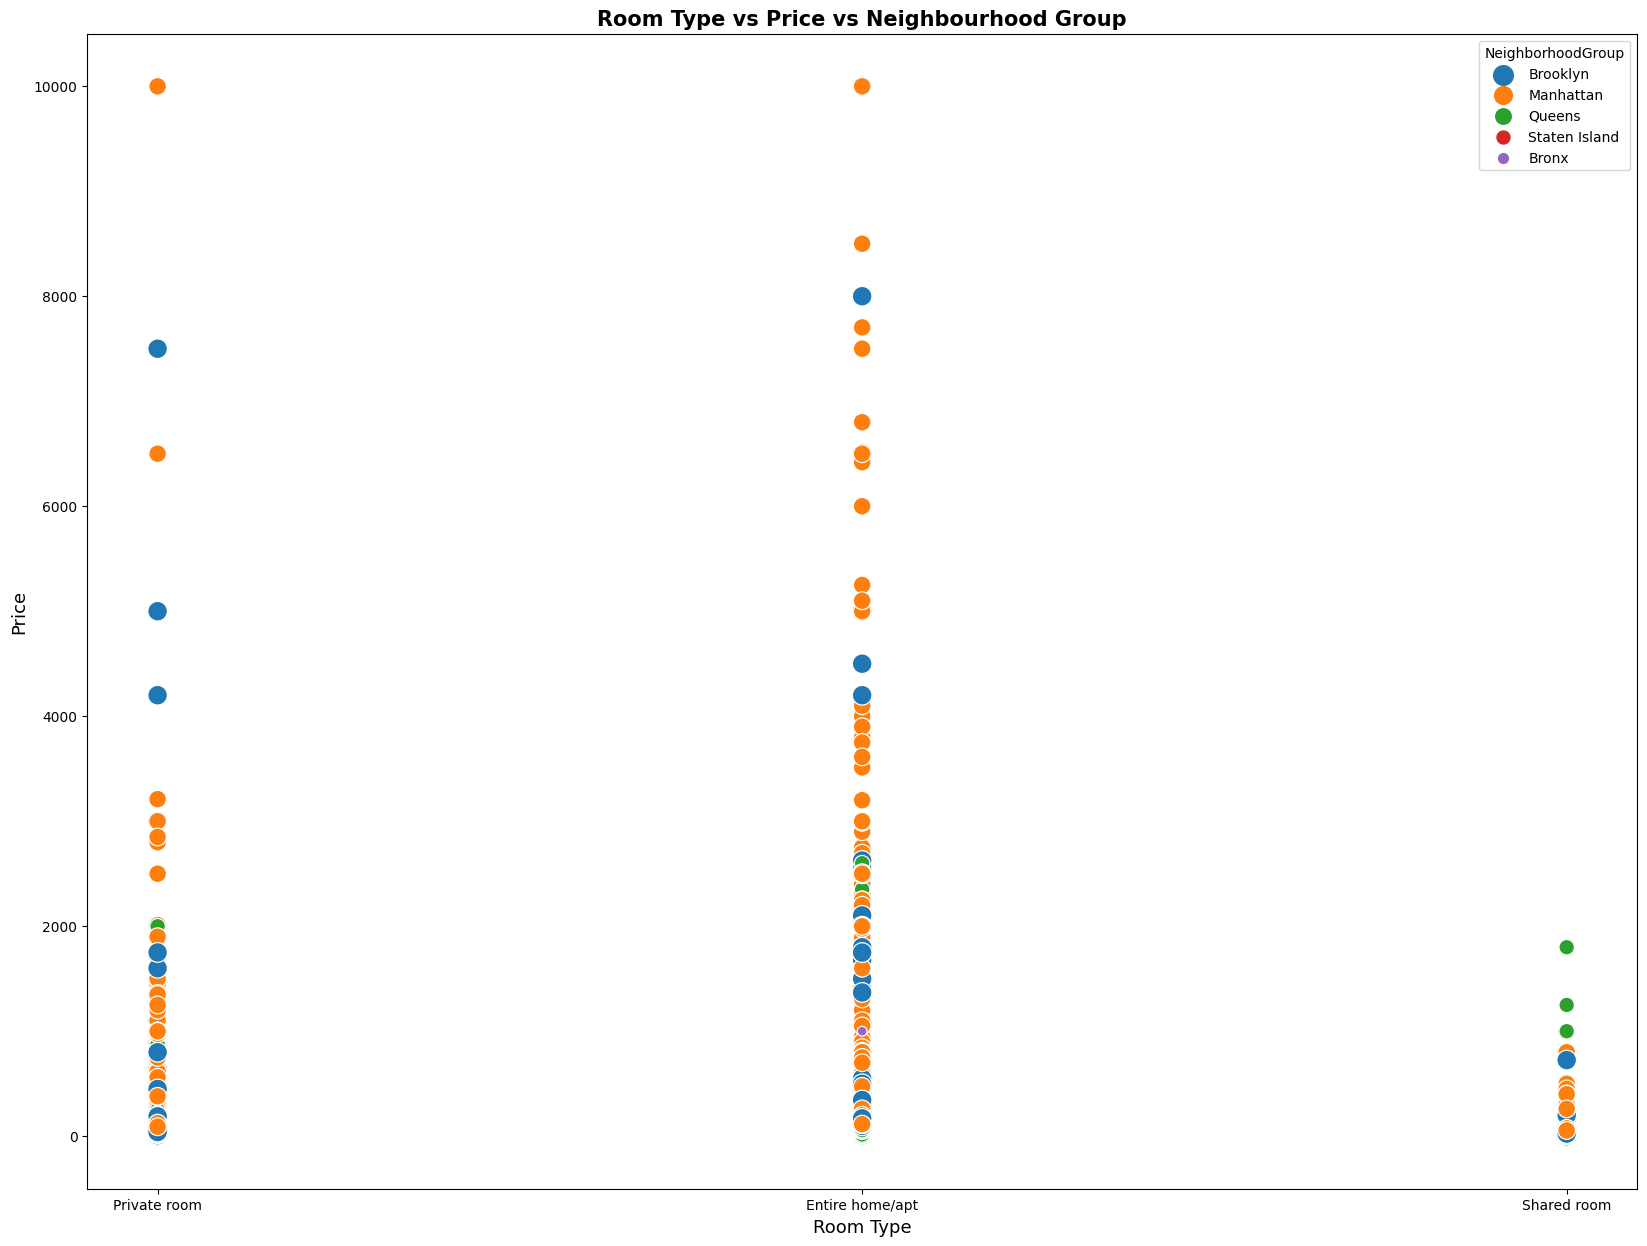

In [14]:
sql7 = 'SELECT Price, NeighborhoodGroup, ListingType FROM Listing L JOIN Neighborhood N ON N.NeighborhoodID = L.NeighborhoodID'
df7  = pd.read_sql_query(sql7, norm_conn)

plt.figure(figsize=(20,15))
sns.scatterplot(x="ListingType", y="Price",
            hue="NeighborhoodGroup", size="NeighborhoodGroup",
            sizes=(50, 200), data=df7)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price vs Neighbourhood Group",size=15, weight='bold')

<h3><em><font color = blue><strong> INFERENCE:
<h3>Upon observing visualization, we can understand the price range of each listing type.

<h2><strong><font color=green> Visualization5

<h3><em><strong>Geographical Distribution of Airbnb Listings by Room/Listing Type in NYC</h8>

In [15]:
sql4 = 'Select Latitude, Longitude, ListingType From Listing'
df4 = pd.read_sql_query(sql4, norm_conn)
fig = px.scatter_mapbox(
    df4,
    lat='Latitude',
    lon='Longitude',
    color='ListingType',
    hover_name='ListingType',
    mapbox_style='carto-positron',
    title='Scatter plot Listings by Room Type IN NYC',
)
fig.update_layout(
    width=800,  # Adjust the width as needed
)
# Show the figure
fig.show()

<h2><font color=green><strong>Visualization 6
<h3><em><strong>Average Listing Price in Different Neighbourhood Groups


In [16]:
sql5 = """
select  NeighborhoodGroup, Round(AVG(L.Price),2) as Average_listing_price
from Listing L join Neighborhood N on
N.NeighborhoodID = L.NeighborhoodID
GROUP by NeighborhoodGroup
order by Average_listing_price desc

"""
df5 = pd.read_sql_query(sql5, norm_conn)
#custom_palette = ['#D9ED92', '#99D98C', '#52B69A',  '#168AAD', '#184E77']
fig = px.bar(
    df5,
    x='NeighborhoodGroup',
    y='Average_listing_price',
    color='NeighborhoodGroup',  # Color bycustom_palette,  # Use the custom pastel color palette
    labels={'NeighborhoodGroup': 'Neighborhood Group', 'Average_listing_price': 'Average Listing Price ($)'},
    title='Average Listing Prices in Neighborhood Group in NYC',
)
fig.update_layout(
    xaxis_title='',
    yaxis_title='Average Listing Price ($)',
    showlegend=False,  # Hide legend since color is used for neighborhood differentiation
    paper_bgcolor='white',  # White
    width = 700
)
fig.show()

<h3><em><font color = blue><strong> INFERENCE:
<h3> Manhattan has highest average listing price of around 197$

<h2><strong><font color=green> Visualization 7

<h3><em><strong>Listing Count and Average Price Across Neighborhood Groups</h3>

In [17]:
# Execute the SQL query and load the result into a DataFrame
query = """
    SELECT count(*) as count_listings, avg(L.price) as Avg_Price, N.NeighborhoodGroup, N.Neighborhood
    FROM Listing as L
    JOIN Neighborhood as N ON N.NeighborhoodID = L.NeighborhoodID
    GROUP BY N.NeighborhoodGroup, N.Neighborhood
"""
df = pd.read_sql_query(query, norm_conn)

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a dropdown with unique neighborhood groups
neighborhood_groups = df['NeighborhoodGroup'].unique()
dropdown_options = [{'label': group, 'value': group} for group in neighborhood_groups]

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("Interactive Dashboard"),

    dcc.Dropdown(
        id='dropdown-neighborhood-group',
        options=dropdown_options,
        value=neighborhood_groups[0],
        multi=False,
    ),

    dcc.Graph(id='bar-chart'),

])

# Define callback to update the bar chart based on dropdown selection
@app.callback(
    Output('bar-chart', 'figure'),
    [Input('dropdown-neighborhood-group', 'value')]
)
def update_chart(selected_neighborhood_group):
    filtered_df = df[df['NeighborhoodGroup'] == selected_neighborhood_group]

    # Create a bar chart
    fig = px.bar(filtered_df, x='Neighborhood', y='count_listings', title=f'Bar Chart for {selected_neighborhood_group}')

    # Add a line chart for average price on a secondary Y-axis
    line_fig = px.line(filtered_df, x='Neighborhood', y='Avg_Price', title=f'Line Chart for {selected_neighborhood_group}',
                       labels={'Avg_Price': 'Average Price'}, line_shape='linear', render_mode='svg')
    # Change the color of the line
    line_color = 'red'  # You can replace 'red' with the color you prefer
    line_fig.update_traces(line=dict(color=line_color))

    # Combine bar and line charts
    fig.add_trace(line_fig['data'][0])

    # Add a secondary Y-axis
    fig.update_layout(yaxis2=dict(title='Average Price', overlaying='y', side='right'))

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

<h2><font color="green"><strong>Visualization 8</strong></font></h2>
<h3><em><strong>Created a  Density map based on price for all Listing to visualize price distribution All over NYC </font></strong></em></h3>
<h3><em><strong>Famous tourist and iconic places are marked as dots</font></strong></em></h3>


In [18]:
attractions_data = {
    "Attraction": [
        "Statue of Liberty", "Central Park", "Times Square",
        "Empire State Building", "Brooklyn Bridge", "The Metropolitan Museum of Art",
        "Grand Central Terminal", "Rockefeller Center", "The High Line",
        "Museum of Modern Art (MoMA)", "One World Observatory", "The Guggenheim Museum",
        "Broadway", "Fifth Avenue", "Chinatown", "Little Italy", "The Bronx Zoo",
        "Coney Island", "The Cloisters", "St. Patrick's Cathedral",
        "The Museum of Natural History", "The Vessel (Hudson Yards)", "The Battery",
        "Washington Square Park", "The New York Public Library", "Radio City Music Hall",
        "The Intrepid Sea, Air & Space Museum", "Staten Island Ferry", "Ellis Island",
        "The Morgan Library & Museum"
    ],
    "Latitude": [
        40.689247, 40.785091, 40.758896,
        40.748817, 40.706086, 40.779437,
        40.752726, 40.758740, 40.747991,
        40.761436, 40.713017, 40.782979,
        40.758896, 40.780836, 40.715751,
        40.719142, 40.850590, 40.574926,
        40.864805, 40.758697, 40.781324,
        40.753590, 40.703278, 40.730823,
        40.753182, 40.759167, 40.764558,
        40.689247, 40.699367, 40.749226
    ],
    "Longitude": [
        -74.044502, -73.968285, -73.985130,
        -73.985428, -73.996864, -73.963244,
        -73.977229, -73.978674, -74.004765,
        -73.977621, -74.013536, -73.958970,
        -73.985130, -73.963646, -73.997031,
        -73.997327, -73.876998, -73.985941,
        -73.931502, -73.976778, -73.973988,
        -74.002625, -74.017028, -73.997332,
        -73.982253, -73.979076, -73.999331,
        -74.044502, -74.040794, -73.981406
    ]
}
attractions_df = pd.DataFrame(attractions_data)

# Your existing code for listing prices
sql6 = 'Select Latitude, Longitude, Price From Listing'
df6 = pd.read_sql_query(sql6, norm_conn)

# Add a new column to distinguish between listings and attractions
df6['Type'] = 'Listing'
attractions_df['Type'] = 'Attraction'

# Concatenate the two DataFrames
combined_df = pd.concat([df6, attractions_df])

# Create the density map with both listings and attractions
fig_listings = px.density_mapbox(
    df6,
    lat='Latitude',
    lon='Longitude',
    z='Price',
    radius=10,
    center=dict(lat=df6['Latitude'].mean(), lon=df6['Longitude'].mean()),
    zoom=10,
    title='Heatmap of Listing Prices',
    labels={'Price': 'Listing Price'},
    mapbox_style='carto-positron',
)

# Create a scatter map for attractions
fig_attractions = px.scatter_mapbox(
    attractions_df,
    lat='Latitude',
    lon='Longitude',
    text='Attraction',
    zoom=10,
    title='Attractions in NYC',
    mapbox_style='carto-positron',
    size_max=30,  # Adjust as needed
)


# Combine the two figures
fig_combined = fig_listings.add_trace(fig_attractions.data[0])
fig_combined.update_layout(
    width=800,  # Adjust the width as needed
)

# Show the combined figure
fig_combined.show()


<h3><em><font color = blue><strong> INFERENCE:
<h3>Upon observing visualization, we can clearly observe that the prices of Listings are higher in Manhattan and Brooklyn and highly dense.

<h2><em>Combining Data from Normalized Database Tables

<ipython-input-19-0f33503d4c24>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Price Distribution Plot')

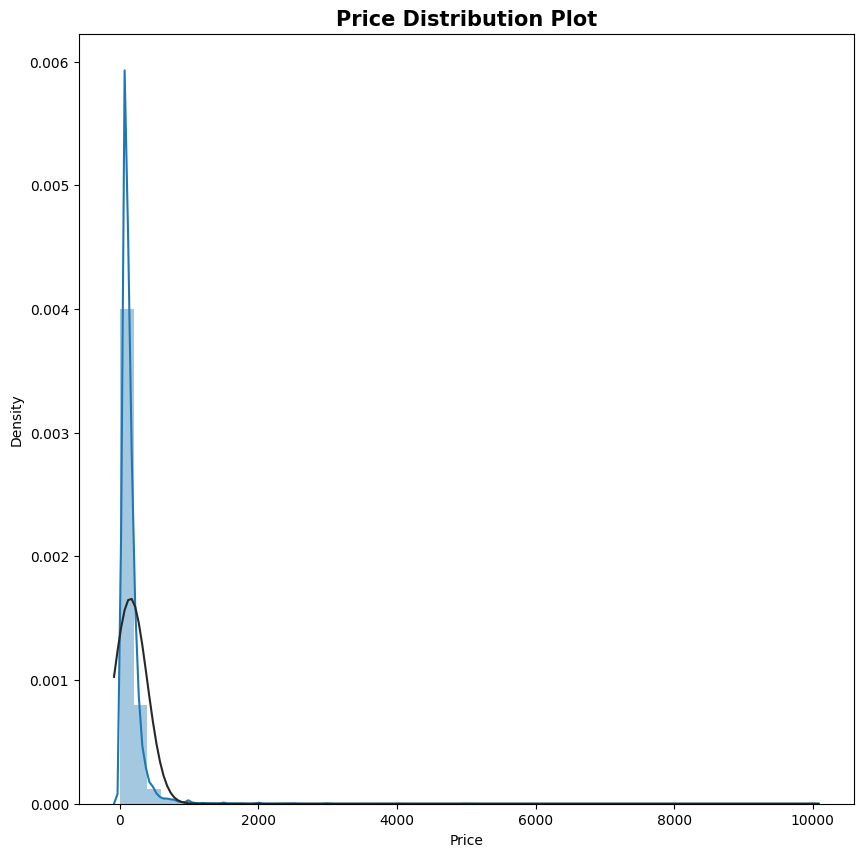

In [19]:
cor_sql ='''
 SELECT *
FROM Listing L
JOIN Host H ON H.HostID = L.HostID
JOIN Neighborhood N ON N.NeighborhoodID=L.NeighborhoodID;
'''
cor_df = pd.read_sql_query(cor_sql, norm_conn)

plt.figure(figsize=(10,10))
sns.distplot(cor_df['Price'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

<h4><strong>In the analysis, we applied a logarithmic transformation to the price variable. This was done to address the right-skewness observed in the original distribution, where a few extremely high prices were impacting the overall shape. The logarithmic transformation helps normalize the distribution, making the data more symmetrical and enhancing the reliability of subsequent analyses and model-building

<ipython-input-20-6fa6bece39b3>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




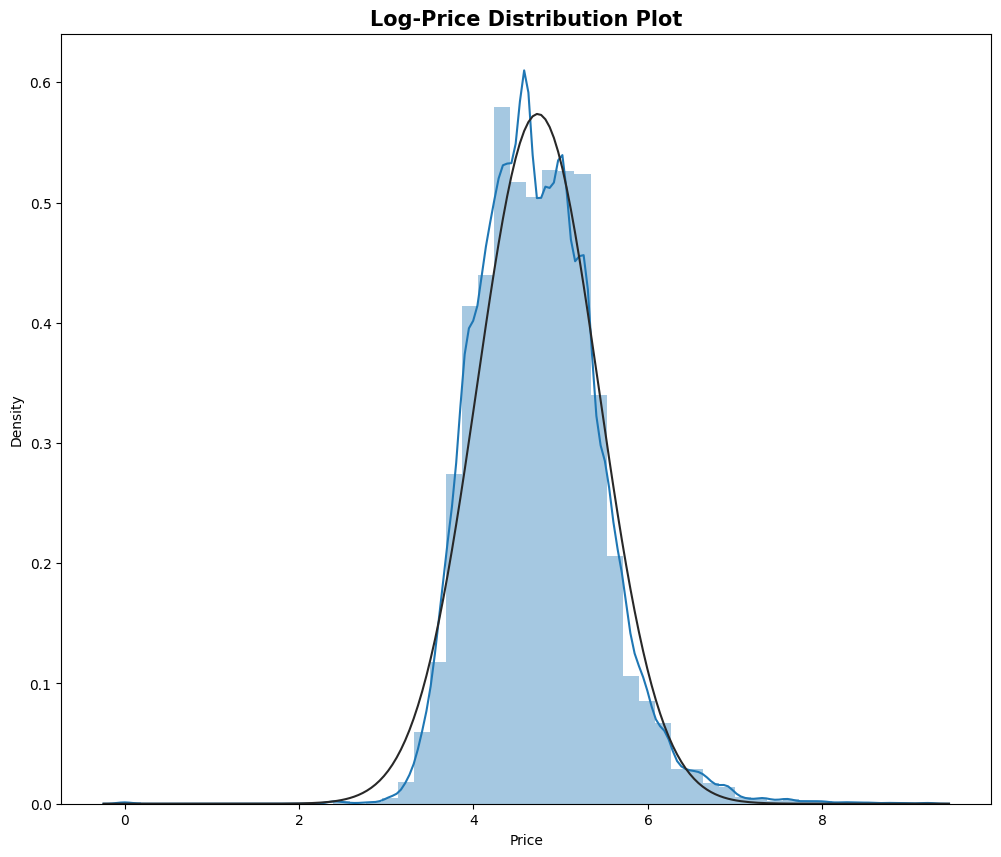

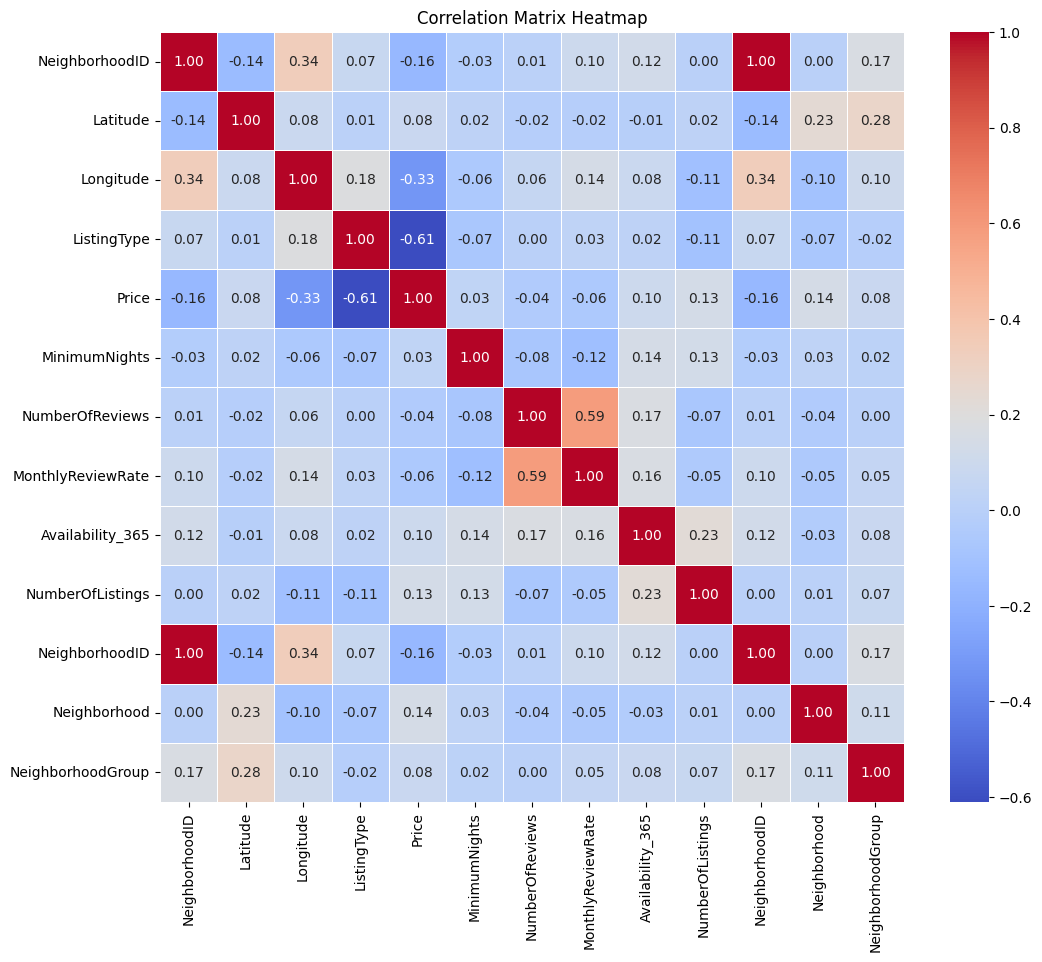

In [20]:
cor_df['Price'] = np.log(cor_df.Price+1)
plt.figure(figsize=(12,10))
sns.distplot(cor_df['Price'], fit=norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

##converting NeighborhoodGroup,Neighborhood,ListingType to catergorical variables to perform Linear regression

cor_df['NeighborhoodGroup']= cor_df['NeighborhoodGroup'].astype("category").cat.codes
cor_df['Neighborhood'] = cor_df['Neighborhood'].astype("category").cat.codes
cor_df['ListingType'] = cor_df['ListingType'].astype("category").cat.codes

#dropping Irrelevant columns
cor_df= cor_df.drop(columns=['ListingName','ListingID' ,'HostID','HostName'])
cor_df.isnull().sum()

# Calculating the correlation matrix
correlation_matrix = cor_df.corr()

# Creating a heatmap using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<H2><EM><strong>Correlation Matrix for Predictors vs Target(Price)

Here, we can see there is a Strong  Negative Co-relation between ListingType and Longitude Predictors


<h1><font color= maroon><strong>Prediction
<h2><em><strong> Predicting Price parameter using Linear Regression Model.

Prices: Actual Vs Predicted
+-------+--------------------+-------------------+
|       |       Actual       |     Predicted     |
+-------+--------------------+-------------------+
|  879  | 4.499809670330265  | 5.160443898720871 |
| 44383 | 3.4339872044851463 | 4.226564397821335 |
| 15394 | 4.795790545596741  | 4.469414410409456 |
| 43230 | 6.154858094016418  | 5.365985079076552 |
| 16332 | 5.298317366548036  | 5.036986919615629 |
+-------+--------------------+-------------------+
Mean Absolute Error: 0.3696795119164751
Mean Squared Error: 0.25441376822824496
R-squared: 0.46222702474717425


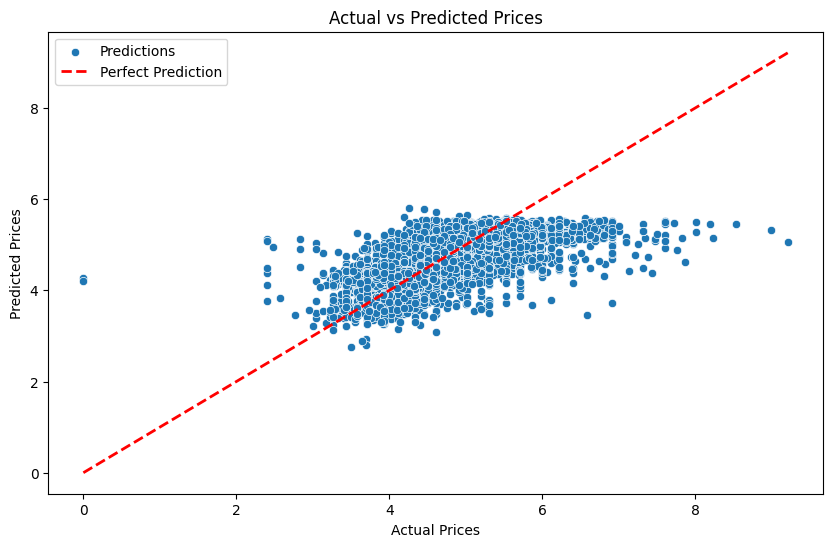

In [21]:
features = ['NumberOfReviews', 'MonthlyReviewRate', 'Availability_365', 'Latitude', 'Longitude', 'NeighborhoodID', 'Neighborhood', 'ListingType']

target = 'Price'

# Select features and target
X = pd.get_dummies(cor_df[features].join(cor_df[['Neighborhood', 'ListingType']], rsuffix='_other'))
y = cor_df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

prices = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
prices = prices.head()

print("Prices: Actual Vs Predicted")
print(tabulate(prices, headers='keys', tablefmt='pretty'))

# Print evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# Scatter plot of actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, label='Predictions')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Add a diagonal line for comparison
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')

plt.legend()
plt.show()





<h2><em><strong> Predicting Price parameter using Ridge Regression Model.

Prices: Actual Vs Predicted
+-------+--------------------+--------------------+
|       |       Actual       |     Predicted      |
+-------+--------------------+--------------------+
|  879  | 4.499809670330265  | 5.160441605795679  |
| 44383 | 3.4339872044851463 | 4.2265737079293055 |
| 15394 | 4.795790545596741  | 4.4694176177638365 |
| 43230 | 6.154858094016418  | 5.365971454652662  |
| 16332 | 5.298317366548036  | 5.036984573265147  |
+-------+--------------------+--------------------+
Mean Squared Error: 0.2544137823537008


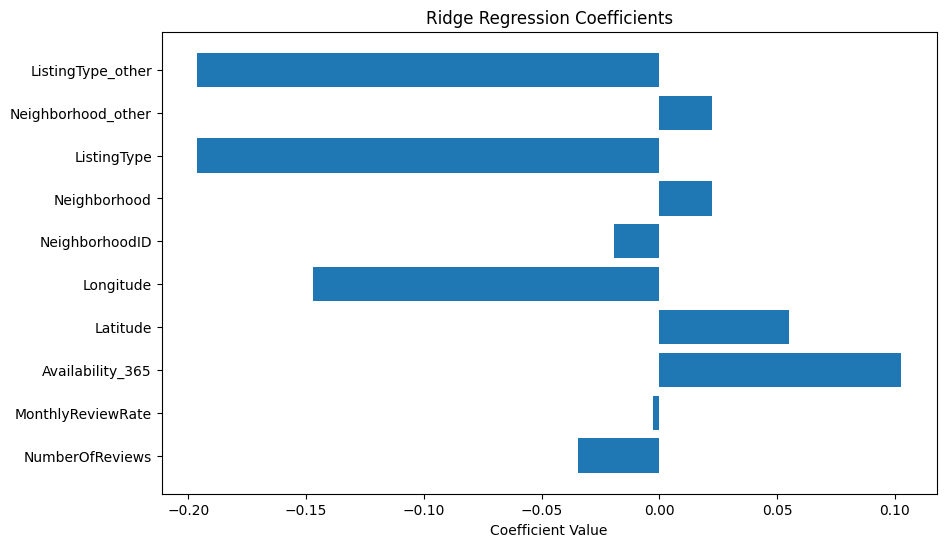

In [22]:
features = ['NumberOfReviews', 'MonthlyReviewRate', 'Availability_365', 'Latitude', 'Longitude', 'NeighborhoodID', 'Neighborhood', 'ListingType']
target = 'Price'

X = pd.get_dummies(cor_df[features].join(cor_df[['Neighborhood', 'ListingType']], rsuffix='_other'))
y = cor_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform Ridge regression
alpha = 1.0
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test_scaled)

prices = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
prices = prices.head()

print("Prices: Actual Vs Predicted")
print(tabulate(prices, headers='keys', tablefmt='pretty'))


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

feature_names = X.columns

# Retrieve the coefficients from the Ridge model
coefficients = ridge_model.coef_

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.title('Ridge Regression Coefficients')
plt.show()

#Conclusion
In this project, we conducted a comprehensive analysis of the New York City Airbnb market, focusing on geographical distribution, pricing dynamics, and customer experiences. Through normalization of the dataset, we created organized tables for hosts, neighborhoods, and listings. Insights revealed Manhattan and Brooklyn as market leaders, short-term rentals' prevalence, and the impact of location on pricing. Applying data transformation and predictive modeling enhanced our understanding, providing valuable insights for hosts and customers in optimizing their Airbnb experiences.

Our comprehensive analysis on the New York City Airbnb market offers valuable insights for both AIRBNB hosts and tourists.
Upon observing the Geographical trends we can conclude Manhattan and Brooklyn as the most dominant areas  in listing count and prices . Airbnb listing are dense around popular tourist spots like times sq , empire st building , central park.
and Entire apartment is most popular listing type.
On futher analysis of availability bins mostly airbnb listings have few availability around the year  which suggests there short-term rental shortage in nyc which explains elevated prices nyc